# FIGURE 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from msresist.pre_processing import preprocessing
from msresist.figures.figure1 import plotClustergram, plotVarReplicates, plotReplicatesEndpoint, plotAveragedEndpoint, plotReplicatesFoldChangeEndpoint, plotVarReplicates, plotpca_explained, plotpca_ScoresLoadings_plotly
import warnings
warnings.simplefilter("ignore")

In [2]:
pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

# 1. Phosphorylation Measurements

### A) PC9 AXL WT SAMPLES 

In [279]:
ABC_wt = preprocessing(AXLwt=True, motifs=True, Vfilter=False, FCfilter=False, log2T=True, mc_col=True)

In [191]:
ABC_wt[ABC_wt["Abbv"].str.contains("BRK1")]

,Protein,Sequence,UniprotAcc,Abbv,Position,PC9,Erl,R428,Erl/R428,Erl+HGF,Erl+FGF,Erl+IGF,KO Erl,KO R428,KO Erl/R428
656,Protein BRICK1,ERRIEyIEARV,Q8WUW1,BRK1,Y63-p,1.0,0.775598,0.770595,0.492224,0.735395,0.663868,0.64909,0.585469,0.716772,0.550101


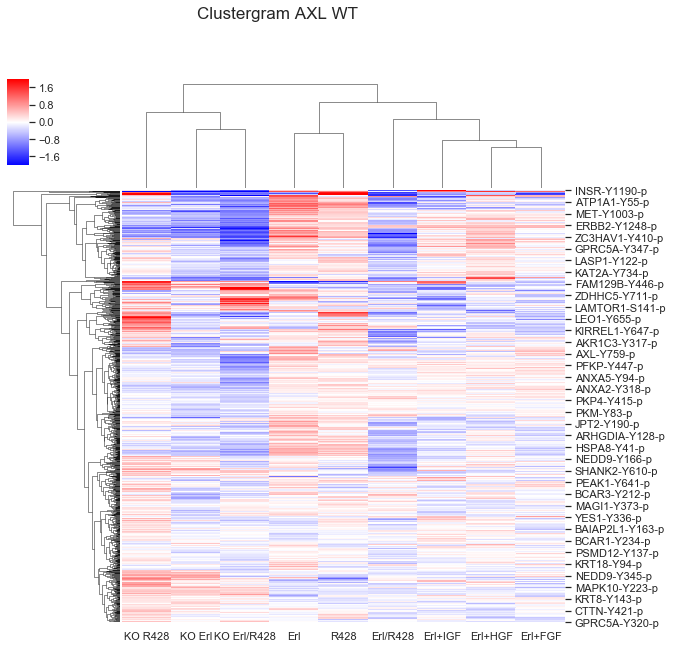

In [117]:
data_wt = pd.concat([ABC_wt.iloc[:, 3:5], ABC_wt.iloc[:, 6:]], axis=1).set_index(["Abbv", "Position"])
plotClustergram(data_wt, "Clustergram AXL WT", 2)

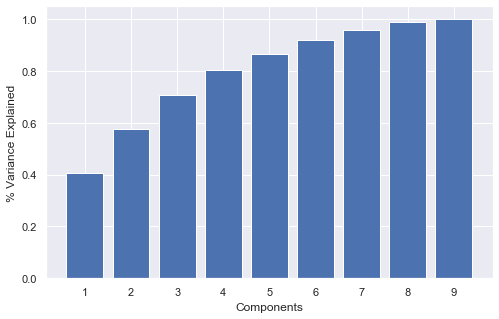

In [118]:
fig, ax = fig, ax = plt.subplots(1, 1, figsize=(8, 5))

plotpca_explained(ax, data_wt, data_wt.shape[1])

In [119]:
plotpca_ScoresLoadings_plotly(data_wt.T, "PC9 cells +Erlotinib", "EGFR")

               PC1       PC2
Position                    
Y1197-p  -0.074140  0.186096
Y1172-p  -0.011331  0.130862
T1131-p  -0.050788  0.207210
Y978-p   -0.043096  0.096696
Y1069-p  -0.029686  0.217113
Y1110-p  -0.037579  0.094229


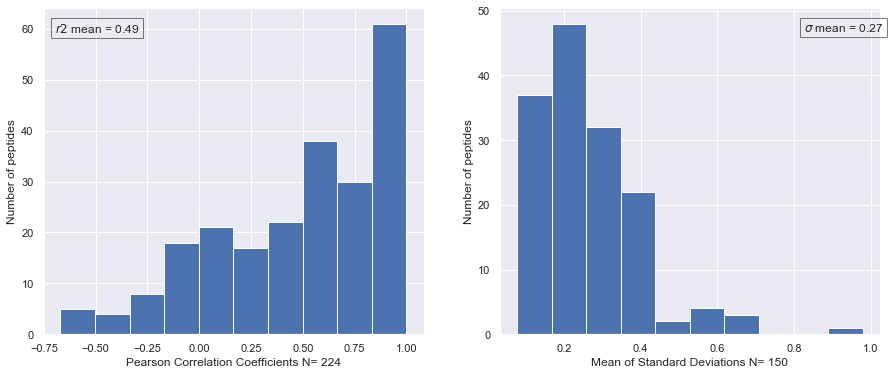

In [9]:
ABCwt_raw = preprocessing(AXLwt=True, rawdata=True, mc_row=True)

fig, ax = plt.subplots(1, 2, figsize=(15,6))
plotVarReplicates(ax, ABCwt_raw)

Variability of overlapping peptides across MS replicates. Pearson's correlation coefficient was computed for peptides overlapping across 2 MS replicates. For those overlapping 3 or more times, the Std was calculated.

### B) PC9 AXL MUTANTS TREATED WITH ERLOTINIB 

In [351]:
ABC_mutErl = preprocessing(Axlmuts_Erl=True, motifs=True, Vfilter=False, FCfilter=False, log2T=True, mc_row=True)

In [235]:
axl = ABC_mutErl[ABC_mutErl["Protein"].str.contains("UFO")]
axl.iloc[:, 5:] = pd.DataFrame(np.power(2, axl.iloc[:, 5:]))
axl

,Protein,Sequence,UniprotAcc,Abbv,Position,PC9,KO,Kd,KI,M4,M5,M7,M10,M11,M15
385,Tyrosine-protein kinase receptor UFO,ENSEIyDYLRQ,P30530,AXL,Y759-p,0.277878,0.347945,0.174307,0.321534,0.451552,0.458850,0.385355,0.508003,0.123590,0.313527
386,Tyrosine-protein kinase receptor UFO,HPAGRyVLCPS,P30530,AXL,Y866-p,1.053965,0.567987,0.556677,2.017359,1.251894,1.713546,2.351833,1.798186,2.231063,2.980473


In [236]:
erk1 = ABC_mutErl[ABC_mutErl["Abbv"].str.contains("MAPK3")]
erk1.iloc[:, 5:] = pd.DataFrame(np.power(2, erk1.iloc[:, 5:]))
erk1

,Protein,Sequence,UniprotAcc,Abbv,Position,PC9,KO,Kd,KI,M4,M5,M7,M10,M11,M15
234,Mitogen-activated protein kinase 3,GFLTEyVATRW,P27361,MAPK3,Y204-p,8.402040,5.403680,5.300643,8.879632,5.738732,5.540718,5.459404,5.039426,6.408356,5.312546
235,Mitogen-activated protein kinase 3,GFLtEyVATRW,P27361,MAPK3,Y204-p,0.369641,0.639697,0.568898,0.652274,0.707578,0.490376,0.694198,0.596328,0.382566,0.509918


In [240]:
erk2 = ABC_mutErl[ABC_mutErl["Abbv"].str.contains("MAPK")]
erk2.iloc[:, 5:] = pd.DataFrame(np.power(2, erk2.iloc[:, 5:]))
erk2

,Protein,Sequence,UniprotAcc,Abbv,Position,PC9,KO,Kd,KI,M4,M5,M7,M10,M11,M15
227,Mitogen-activated protein kinase 1,GFLTEyVATRW,P28482,MAPK1,Y187-p,26.827242,13.699512,20.169048,27.123886,16.000352,14.449345,19.377623,14.493517,24.485321,16.449727
228,Mitogen-activated protein kinase 1,GFLtEyVATRW,P28482,MAPK1,Y187-p,1.521066,2.853586,2.324980,3.224176,3.028650,2.908285,3.277799,3.120451,1.584956,2.077980
229,Mitogen-activated protein kinase 10,FMMTPyVVTRY,P53779,MAPK10,Y223-p,2.024591,2.994264,3.718396,3.189698,2.748332,2.899126,3.188818,3.246403,3.869635,3.190726
230,Mitogen-activated protein kinase 10,FMMtPyVVTRY,P53779,MAPK10,Y223-p,0.407816,0.575696,0.406614,0.370032,0.756989,0.885274,0.550980,0.560048,0.517076,0.525443
231,Mitogen-activated protein kinase 12,SEMTGyVVTRW,P53778,MAPK12,Y185-p,4.249533,4.774402,5.362267,5.947052,3.870996,5.654477,5.925501,5.220750,8.960509,4.372070
232,Mitogen-activated protein kinase 13,AEMTGyVVTRW,O15264,MAPK13,Y182-p,6.019478,6.306950,8.507772,8.736767,5.065238,5.928582,7.932098,5.938195,14.544482,6.368044
233,Mitogen-activated protein kinase 14,DEMTGyVATRW,Q16539,MAPK14,Y182-p,1.453321,1.390572,2.704389,2.208992,1.114838,1.553177,2.089455,1.481383,3.296184,1.988715
234,Mitogen-activated protein kinase 3,GFLTEyVATRW,P27361,MAPK3,Y204-p,8.402040,5.403680,5.300643,8.879632,5.738732,5.540718,5.459404,5.039426,6.408356,5.312546
235,Mitogen-activated protein kinase 3,GFLtEyVATRW,P27361,MAPK3,Y204-p,0.369641,0.639697,0.568898,0.652274,0.707578,0.490376,0.694198,0.596328,0.382566,0.509918
236,Mitogen-activated protein kinase 7,YFMTEyVATRW,Q13164,MAPK7,Y221-p,0.280496,0.320399,0.228196,0.420443,0.338334,0.348242,0.314890,0.242687,0.205948,0.194875


In [243]:
erk2 = ABC_mutErl[ABC_mutErl["Abbv"].str.contains("MET")]
erk2.iloc[:, 5:] = pd.DataFrame(np.power(2, erk2.iloc[:, 5:]))
erk2

,Protein,Sequence,UniprotAcc,Abbv,Position,PC9,KO,Kd,KI,M4,M5,M7,M10,M11,M15
173,Hepatocyte growth factor receptor,KCVAPyPSLLS,P08581,MET,Y1365-p,0.585241,0.429347,0.531817,0.301242,0.481055,0.492278,0.466817,0.435194,0.600274,0.368910
174,Hepatocyte growth factor receptor,NESVDyRATFP,P08581,MET,Y1003-p,1.212596,0.846296,0.867750,0.950178,0.760937,0.785473,0.726585,0.801151,0.822003,0.966591


In [282]:
ABC_mutErl = pd.concat([ABC_mutErl.iloc[:, :12], ABC_mutErl.iloc[:, 14]], axis=1)

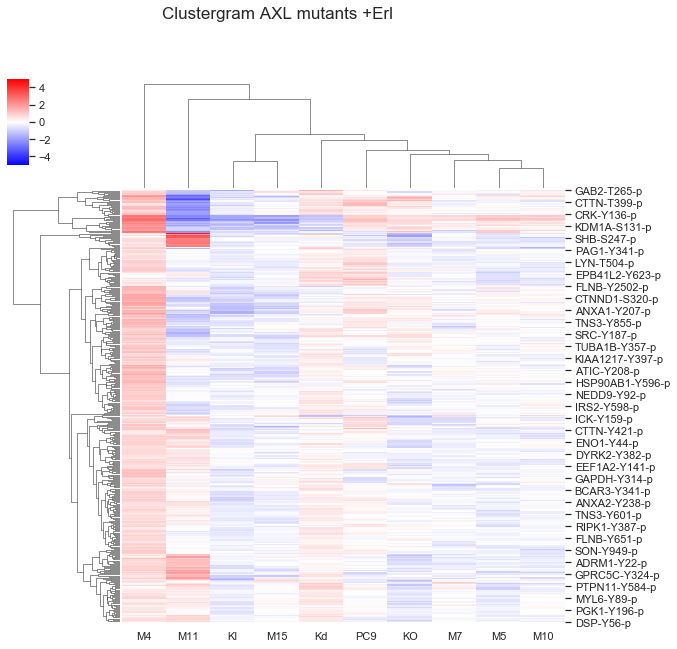

In [352]:
data_mutErl = pd.concat([ABC_mutErl.iloc[:, 3:5], ABC_mutErl.iloc[:, 5:]], axis=1).set_index(["Abbv", "Position"])
plotClustergram(data_mutErl, "Clustergram AXL mutants +Erl", lim=5)

In [247]:
axl = ABC_mutErl[ABC_mutErl["Protein"].str.contains("UFO")]
axl.iloc[:, 5:] = pd.DataFrame(np.power(2, axl.iloc[:, 5:])).div(np.power(2, axl.iloc[:, 5]), axis=0)
axl

,Protein,Sequence,UniprotAcc,Abbv,Position,PC9,KO,Kd,KI,M4,M5,M7,M15
385,Tyrosine-protein kinase receptor UFO,ENSEIyDYLRQ,P30530,AXL,Y759-p,1.0,1.252151,0.627278,1.157104,1.625000,1.651263,1.386775,1.128289
386,Tyrosine-protein kinase receptor UFO,HPAGRyVLCPS,P30530,AXL,Y866-p,1.0,0.538905,0.528174,1.914066,1.187795,1.625809,2.231415,2.827866


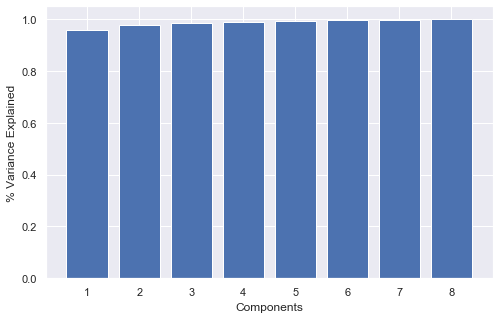

In [248]:
fig, ax = fig, ax = plt.subplots(1, 1, figsize=(8, 5))

plotpca_explained(ax, data_mutErl, data_mutErl.shape[1])

In [310]:
plotpca_ScoresLoadings_plotly(data_mutErl.T, "PC9 AXL mutants +Erlotinib", "EGFR")

               PC1       PC2
Position                    
Y1197-p   0.027613  0.147668
Y1172-p   0.013089  0.040362
Y1069-p   0.013982 -0.010382


In [192]:
bcar1 = ABC_mutErl[ABC_mutErl["Abbv"].str.contains("BCAR1")]
bcar1.iloc[:, 5:] = pd.DataFrame(np.power(2, bcar1.iloc[:, 5:])).div(np.power(2, bcar1.iloc[:, 5]), axis=0)
bcar1

,Protein,Sequence,UniprotAcc,Abbv,Position,PC9,KO,Kd,KI,M4,M5,M7,M10,M11,M15
48,Breast cancer anti-estrogen resistance protein 1,AQQGLyQVPGP,P56945,BCAR1,Y128-p,1.0,0.773692,0.932598,1.162553,0.932170,0.783753,0.837641,0.671642,0.903953,0.928127
49,Breast cancer anti-estrogen resistance protein 1,GGVVDsGVYAV,P56945,BCAR1,S407-p,1.0,0.980089,0.340023,0.426945,1.342692,0.893203,0.666229,0.912812,0.242477,0.162038
50,Breast cancer anti-estrogen resistance protein 1,GPGTLyDVPRE,P56945,BCAR1,Y387-p,1.0,0.782608,1.394171,1.609689,1.004811,0.926422,0.942170,0.722645,1.683481,1.361646
51,Breast cancer anti-estrogen resistance protein 1,GPQDIyDVPPV,P56945,BCAR1,Y249-p,1.0,2.052963,1.708723,1.312785,1.114266,1.041134,1.310519,1.033741,0.979006,1.431306
52,Breast cancer anti-estrogen resistance protein 1,LAKALyDNVAE,P56945,BCAR1,Y12-p,1.0,1.417216,1.273430,1.356645,1.139121,1.233162,1.338072,1.277491,1.219306,1.354294


In [192]:
bcar1 = ABC_mutErl[ABC_mutErl["Abbv"].str.contains("BCAR1")]
bcar1.iloc[:, 5:] = pd.DataFrame(np.power(2, bcar1.iloc[:, 5:])).div(np.power(2, bcar1.iloc[:, 5]), axis=0)
bcar1

,Protein,Sequence,UniprotAcc,Abbv,Position,PC9,KO,Kd,KI,M4,M5,M7,M10,M11,M15
48,Breast cancer anti-estrogen resistance protein 1,AQQGLyQVPGP,P56945,BCAR1,Y128-p,1.0,0.773692,0.932598,1.162553,0.932170,0.783753,0.837641,0.671642,0.903953,0.928127
49,Breast cancer anti-estrogen resistance protein 1,GGVVDsGVYAV,P56945,BCAR1,S407-p,1.0,0.980089,0.340023,0.426945,1.342692,0.893203,0.666229,0.912812,0.242477,0.162038
50,Breast cancer anti-estrogen resistance protein 1,GPGTLyDVPRE,P56945,BCAR1,Y387-p,1.0,0.782608,1.394171,1.609689,1.004811,0.926422,0.942170,0.722645,1.683481,1.361646
51,Breast cancer anti-estrogen resistance protein 1,GPQDIyDVPPV,P56945,BCAR1,Y249-p,1.0,2.052963,1.708723,1.312785,1.114266,1.041134,1.310519,1.033741,0.979006,1.431306
52,Breast cancer anti-estrogen resistance protein 1,LAKALyDNVAE,P56945,BCAR1,Y12-p,1.0,1.417216,1.273430,1.356645,1.139121,1.233162,1.338072,1.277491,1.219306,1.354294


In [192]:
bcar1 = ABC_mutErl[ABC_mutErl["Abbv"].str.contains("BCAR1")]
bcar1.iloc[:, 5:] = pd.DataFrame(np.power(2, bcar1.iloc[:, 5:])).div(np.power(2, bcar1.iloc[:, 5]), axis=0)
bcar1

,Protein,Sequence,UniprotAcc,Abbv,Position,PC9,KO,Kd,KI,M4,M5,M7,M10,M11,M15
48,Breast cancer anti-estrogen resistance protein 1,AQQGLyQVPGP,P56945,BCAR1,Y128-p,1.0,0.773692,0.932598,1.162553,0.932170,0.783753,0.837641,0.671642,0.903953,0.928127
49,Breast cancer anti-estrogen resistance protein 1,GGVVDsGVYAV,P56945,BCAR1,S407-p,1.0,0.980089,0.340023,0.426945,1.342692,0.893203,0.666229,0.912812,0.242477,0.162038
50,Breast cancer anti-estrogen resistance protein 1,GPGTLyDVPRE,P56945,BCAR1,Y387-p,1.0,0.782608,1.394171,1.609689,1.004811,0.926422,0.942170,0.722645,1.683481,1.361646
51,Breast cancer anti-estrogen resistance protein 1,GPQDIyDVPPV,P56945,BCAR1,Y249-p,1.0,2.052963,1.708723,1.312785,1.114266,1.041134,1.310519,1.033741,0.979006,1.431306
52,Breast cancer anti-estrogen resistance protein 1,LAKALyDNVAE,P56945,BCAR1,Y12-p,1.0,1.417216,1.273430,1.356645,1.139121,1.233162,1.338072,1.277491,1.219306,1.354294


In [192]:
bcar1 = ABC_mutErl[ABC_mutErl["Abbv"].str.contains("BCAR1")]
bcar1.iloc[:, 5:] = pd.DataFrame(np.power(2, bcar1.iloc[:, 5:])).div(np.power(2, bcar1.iloc[:, 5]), axis=0)
bcar1

,Protein,Sequence,UniprotAcc,Abbv,Position,PC9,KO,Kd,KI,M4,M5,M7,M10,M11,M15
48,Breast cancer anti-estrogen resistance protein 1,AQQGLyQVPGP,P56945,BCAR1,Y128-p,1.0,0.773692,0.932598,1.162553,0.932170,0.783753,0.837641,0.671642,0.903953,0.928127
49,Breast cancer anti-estrogen resistance protein 1,GGVVDsGVYAV,P56945,BCAR1,S407-p,1.0,0.980089,0.340023,0.426945,1.342692,0.893203,0.666229,0.912812,0.242477,0.162038
50,Breast cancer anti-estrogen resistance protein 1,GPGTLyDVPRE,P56945,BCAR1,Y387-p,1.0,0.782608,1.394171,1.609689,1.004811,0.926422,0.942170,0.722645,1.683481,1.361646
51,Breast cancer anti-estrogen resistance protein 1,GPQDIyDVPPV,P56945,BCAR1,Y249-p,1.0,2.052963,1.708723,1.312785,1.114266,1.041134,1.310519,1.033741,0.979006,1.431306
52,Breast cancer anti-estrogen resistance protein 1,LAKALyDNVAE,P56945,BCAR1,Y12-p,1.0,1.417216,1.273430,1.356645,1.139121,1.233162,1.338072,1.277491,1.219306,1.354294


In [192]:
bcar1 = ABC_mutErl[ABC_mutErl["Abbv"].str.contains("BCAR1")]
bcar1.iloc[:, 5:] = pd.DataFrame(np.power(2, bcar1.iloc[:, 5:])).div(np.power(2, bcar1.iloc[:, 5]), axis=0)
bcar1

,Protein,Sequence,UniprotAcc,Abbv,Position,PC9,KO,Kd,KI,M4,M5,M7,M10,M11,M15
48,Breast cancer anti-estrogen resistance protein 1,AQQGLyQVPGP,P56945,BCAR1,Y128-p,1.0,0.773692,0.932598,1.162553,0.932170,0.783753,0.837641,0.671642,0.903953,0.928127
49,Breast cancer anti-estrogen resistance protein 1,GGVVDsGVYAV,P56945,BCAR1,S407-p,1.0,0.980089,0.340023,0.426945,1.342692,0.893203,0.666229,0.912812,0.242477,0.162038
50,Breast cancer anti-estrogen resistance protein 1,GPGTLyDVPRE,P56945,BCAR1,Y387-p,1.0,0.782608,1.394171,1.609689,1.004811,0.926422,0.942170,0.722645,1.683481,1.361646
51,Breast cancer anti-estrogen resistance protein 1,GPQDIyDVPPV,P56945,BCAR1,Y249-p,1.0,2.052963,1.708723,1.312785,1.114266,1.041134,1.310519,1.033741,0.979006,1.431306
52,Breast cancer anti-estrogen resistance protein 1,LAKALyDNVAE,P56945,BCAR1,Y12-p,1.0,1.417216,1.273430,1.356645,1.139121,1.233162,1.338072,1.277491,1.219306,1.354294


In [192]:
bcar1 = ABC_mutErl[ABC_mutErl["Abbv"].str.contains("BCAR1")]
bcar1.iloc[:, 5:] = pd.DataFrame(np.power(2, bcar1.iloc[:, 5:])).div(np.power(2, bcar1.iloc[:, 5]), axis=0)
bcar1

,Protein,Sequence,UniprotAcc,Abbv,Position,PC9,KO,Kd,KI,M4,M5,M7,M10,M11,M15
48,Breast cancer anti-estrogen resistance protein 1,AQQGLyQVPGP,P56945,BCAR1,Y128-p,1.0,0.773692,0.932598,1.162553,0.932170,0.783753,0.837641,0.671642,0.903953,0.928127
49,Breast cancer anti-estrogen resistance protein 1,GGVVDsGVYAV,P56945,BCAR1,S407-p,1.0,0.980089,0.340023,0.426945,1.342692,0.893203,0.666229,0.912812,0.242477,0.162038
50,Breast cancer anti-estrogen resistance protein 1,GPGTLyDVPRE,P56945,BCAR1,Y387-p,1.0,0.782608,1.394171,1.609689,1.004811,0.926422,0.942170,0.722645,1.683481,1.361646
51,Breast cancer anti-estrogen resistance protein 1,GPQDIyDVPPV,P56945,BCAR1,Y249-p,1.0,2.052963,1.708723,1.312785,1.114266,1.041134,1.310519,1.033741,0.979006,1.431306
52,Breast cancer anti-estrogen resistance protein 1,LAKALyDNVAE,P56945,BCAR1,Y12-p,1.0,1.417216,1.273430,1.356645,1.139121,1.233162,1.338072,1.277491,1.219306,1.354294


### C) PC9 AXL MUTANTS TREATED WITH ERLOTINIB AND F154

In [329]:
ABC_mutF154 = preprocessing(Axlmuts_ErlF154=True, motifs=True, Vfilter=False, FCfilter=False, log2T=True, mc_row=True)

In [330]:
axl = ABC_mutF154[ABC_mutF154["Abbv"].str.contains("AXL")]
axl.iloc[:, 5:] = pd.DataFrame(np.power(2, axl.iloc[:, 5:]))
axl

,Protein,Sequence,UniprotAcc,Abbv,Position,PC9 A,KO A,Kd A,KI A,M4 A,M5 A,M7 A,M10 A,M11 A,M15 A
371,Tyrosine-protein kinase receptor UFO,ENSEIyDYLRQ,P30530,AXL,Y759-p,0.776403,0.571202,0.488975,1.092877,1.185361,1.279310,1.349424,2.046780,0.649722,1.550571
372,Tyrosine-protein kinase receptor UFO,HPAGRyVLCPS,P30530,AXL,Y866-p,1.394907,0.254523,0.463483,0.750987,1.109877,1.065548,1.537679,1.328558,1.847505,1.812937
373,Tyrosine-protein kinase receptor UFO,IYNGDyYRQGR,P30530,AXL,Y702-p,1.172662,0.144163,0.128262,1.339313,1.162014,3.168843,0.402526,2.243775,3.268276,3.168024


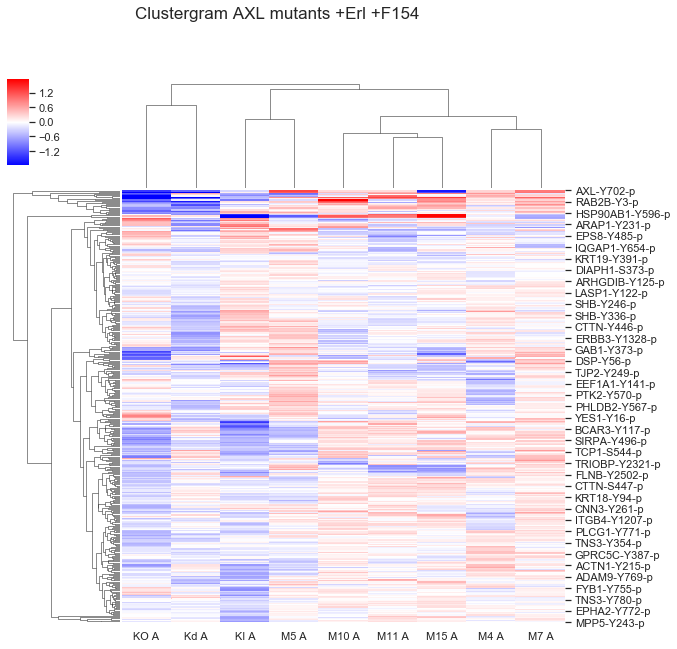

In [345]:
data_mutF154 = pd.concat([ABC_mutF154.iloc[:, 3:5], ABC_mutF154.iloc[:, 6:]], axis=1).set_index(["Abbv", "Position"])
plotClustergram(data_mutF154, "Clustergram AXL mutants +Erl +F154",  max(np.max(np.abs(data_mutF154)) * 0.6))

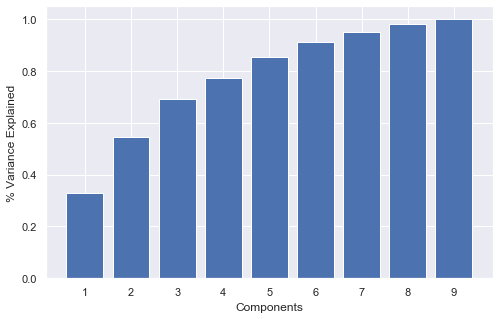

In [346]:
fig, ax = fig, ax = plt.subplots(1, 1, figsize=(8, 5))

plotpca_explained(ax, data_mutF154, data_mutF154.shape[1])

In [350]:
plotpca_ScoresLoadings_plotly(data_mutF154.T, "PC9 +Erl +F154", "GSK3A")

               PC1       PC2
Position                    
Y279-p    0.143732 -0.100897
S278-p   -0.032353  0.030760


### D) CONCATENATING BOTH AXL MUTANT DATA SETS AND SETTING FOLD CHANGE TO PC9 + ERLOTINIB

In [20]:
ABC_mutErl_raw = pd.read_csv("./msresist/data/Raw/PC9_mutants_unstim_BR1_raw.csv")
ABC_mutF154_raw = pd.read_csv("./msresist/data/Raw/PC9_mutants_ActivatingAb_BR1_raw.csv")

In [21]:
from msresist.sequence_analysis import FormatName

ln, sn = FormatName(ABC_mutErl_raw)
ABC_mutErl_raw["Protein"] = ln
ABC_mutErl_raw = ABC_mutErl_raw.assign(Abbv=sn)

ln, sn = FormatName(ABC_mutF154_raw)
ABC_mutF154_raw["Protein"] = ln
ABC_mutF154_raw = ABC_mutF154_raw.assign(Abbv=sn)

In [22]:
from msresist.pre_processing import MapOverlappingPeptides

ABC_mutF154_raw.columns = ABC_mutErl_raw.columns

_, overlap, _ = MapOverlappingPeptides(pd.concat([ABC_mutF154_raw, ABC_mutErl_raw]))

In [23]:
ABC_mutErl = ABC_mutErl_raw.set_index(["Protein", "Sequence"])
ABC_mutF154 = ABC_mutF154_raw.set_index(["Protein", "Sequence"])

prots = list(overlap.iloc[:, 0])
seqs = list(overlap.iloc[:, 1])

ERL, F154 = [], []
for i in range(overlap.shape[0]):
    ERL.append(ABC_mutErl.loc[prots[i], seqs[i]])
    F154.append(ABC_mutF154.loc[prots[i], seqs[i]])

ERL = pd.DataFrame(ERL).reset_index()
F154 = pd.DataFrame(F154).reset_index().iloc[:, 1:]

In [24]:
ABC_mutF154.columns = list(ABC_mutF154.columns[:1]) + [col + str(" + F154") for col in list(ABC_mutF154.columns)[1:]]
F154.columns = ABC_mutF154.columns

In [25]:
conc = pd.concat([ERL, F154.iloc[:, 1:10]], axis=1).set_index("Abbv").iloc[:, 2:]
conc = np.log(conc.div(conc.iloc[:, 0], axis=0))

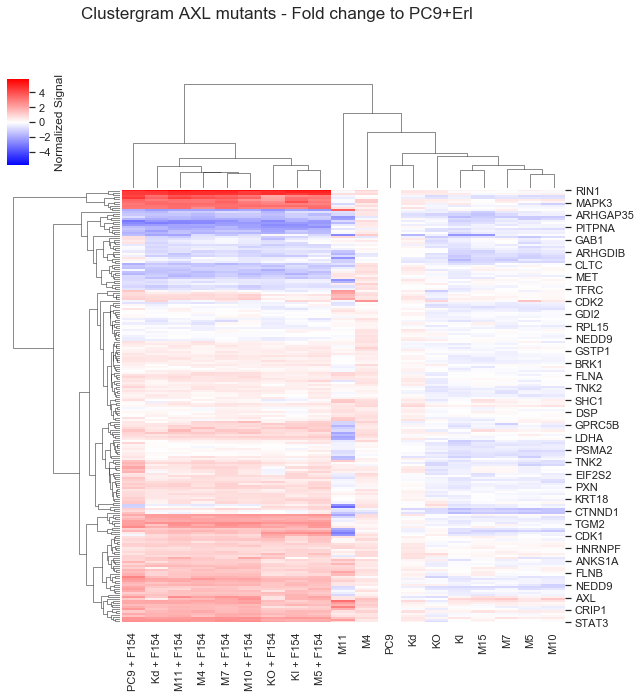

In [26]:
import seaborn as sns

g = sns.clustermap(conc, method="complete", robust=True, vmax=max(np.max(np.abs(conc))), vmin=-max(np.max(np.abs(conc))), cmap="bwr", col_cluster=True, cbar_kws={"label":"Normalized Signal"})
g.fig.suptitle( "Clustergram AXL mutants - Fold change to PC9+Erl", fontsize=17)
ax = g.ax_heatmap
ax.set_ylabel("");

## 2. Cell Viability Measurements:

Average between two replicates. Fold-change 72h vs 0h.

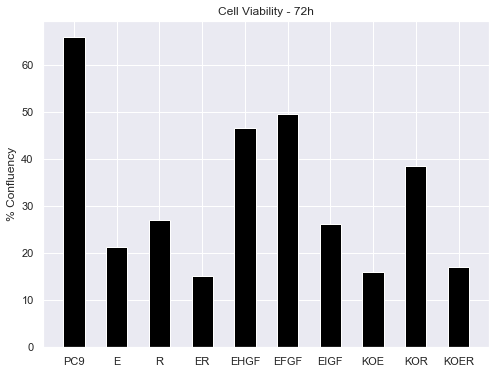

In [27]:
Y_cv1 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw3.csv').iloc[:30, :11]
Y_cv2 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw4.csv').iloc[:29, :11]

fig, ax = plt.subplots(1, 1, figsize=(8,6))
plotAveragedEndpoint(ax, Y_cv1, Y_cv2)

Raw Measurements of both replicates. Initial seeding was clearly off in Exp4.

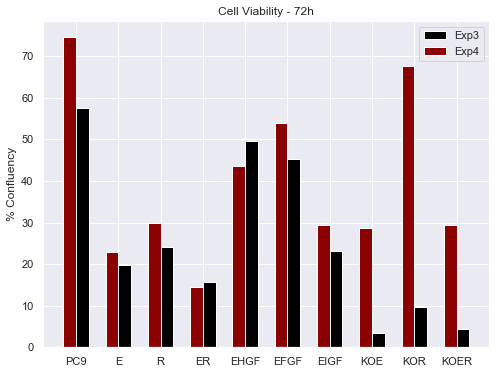

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
plotReplicatesEndpoint(ax, Y_cv1, Y_cv2)

However, by fold-changing to t=0h, both replicates are notably reproducible:

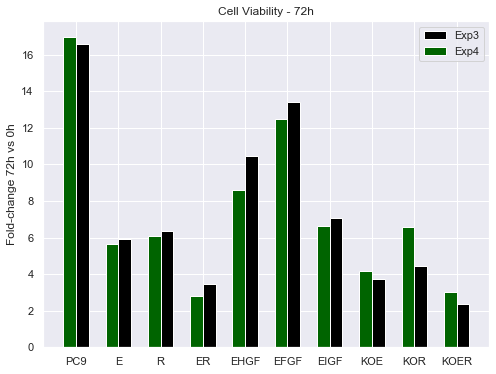

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
plotReplicatesFoldChangeEndpoint(ax, Y_cv1, Y_cv2)

## Cell Viability levels of RIPK1-Transfected PC9 cells

In [30]:
Time = pd.read_csv('./msresist/data/Phenotypic_data/RIPK1_CV_PC9_samples_raw_byRow.csv', delimiter='\t').iloc[:, 1]
full = pd.read_csv('./msresist/data/Phenotypic_data/RIPK1_CV_PC9_samples_raw_byRow.csv', delimiter='\t').iloc[:, 2:]

In [31]:
avg_full = np.zeros((20, 24))
for i in range(full.shape[0]):
    for j in range(int(full.shape[1]/3)):
        avg_full[i, j] = full.iloc[i, j*3:(j+1)*3].mean()
        
avg_full = pd.DataFrame(avg_full)

In [32]:
full = pd.concat([Time, avg_full], axis=1)
full.columns = ["Elapsed", ".8_wt+fbs", ".8_wt-fbs", ".8_YF+fbs", ".8_YF-fbs", 
                "1_wt+fbs", "1_wt-fbs", "1_YF+fbs", "1_YF-fbs",
                "1.3_wt+fbs", "1.3_wt-fbs","1.3_YF+fbs", "1.3_YF-fbs",
                "1.5_wt+fbs", "1.5_wt-fbs","1.5_YF+fbs", "1.5_YF-fbs",
                "2_wt+fbs", "2_wt-fbs","2_YF+fbs", "2_YF-fbs",
                "3_wt+fbs", "3_wt-fbs", "3_YF+fbs", "3_YF-fbs"]

full = full.set_index("Elapsed")

In [33]:
Xidx = [i for i in range(0,24,2)]
full = full.iloc[:, Xidx]

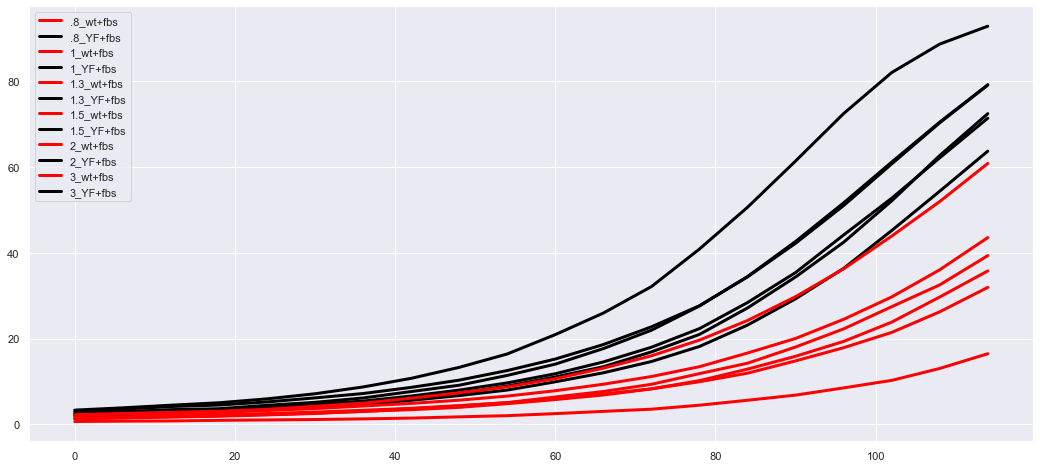

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))

for i in range(12):
    if i in [j for j in range(0, 12, 2)]:
        ax.plot(full.iloc[:, i], label=full.columns[i], linewidth=3, color="red")
    else:
        ax.plot(full.iloc[:, i], label=full.columns[i], linewidth=3, color="black")

ax.legend(loc=2);

In [35]:
full = full.reset_index()

In [36]:
import scipy as sp

Y_cv0 = full[full["Elapsed"] == 0].iloc[0, 1:]
Y_fc108 = full[full["Elapsed"] == 108].iloc[0, 1:] / Y_cv0

print(sp.stats.pearsonr(Y_cv0, Y_fc108)[1])
assert sp.stats.pearsonr(Y_cv0, Y_fc108)[1] > 0.05, "cell seeding effect"

for ii in range(1, full.columns.size):
    full.iloc[:, ii] /= full.iloc[0, ii]

0.14426943843606974


In [37]:
full = full.set_index("Elapsed")

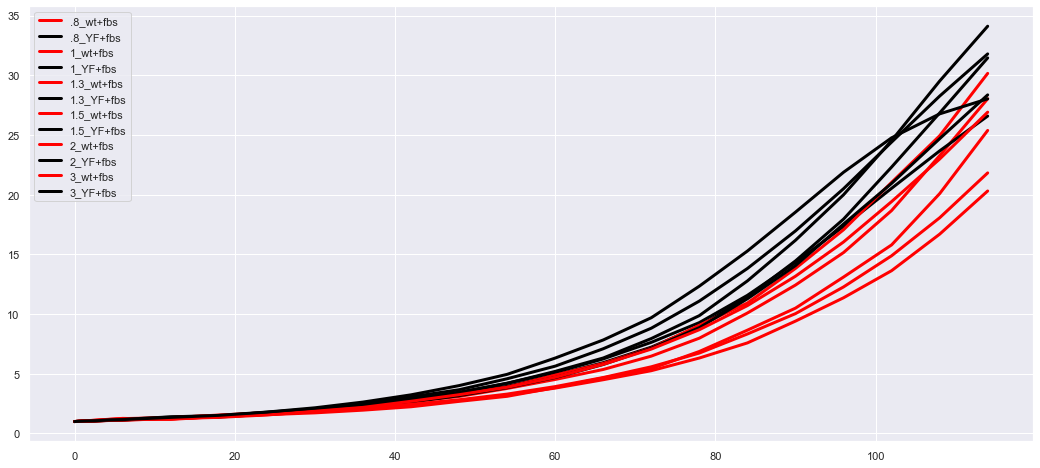

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))

for i in range(12):
    if i in [j for j in range(0, 12, 2)]:
        ax.plot(full.iloc[:, i], label=full.columns[i], linewidth=3, color="red")
    else:
        ax.plot(full.iloc[:, i], label=full.columns[i], linewidth=3, color="black")

ax.legend(loc=2)

In [39]:
full = full.reset_index()

Text(0, 0.5, 'fold-change confluency')

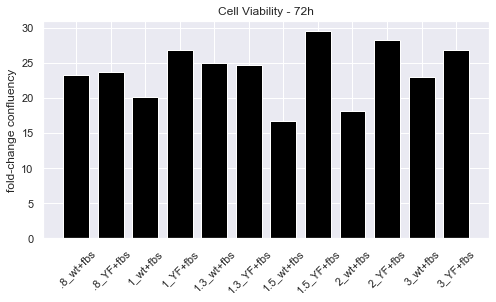

In [40]:
fig, ax = plt.subplots(1, figsize=(8,4))

range_ = np.linspace(1, 12, 12)

ax.set_title("Cell Viability - 72h")
ax.set_xticks(np.arange(1, 13, 1))
ax.set_xticklabels(full.columns[1:], rotation=45)
ax.bar(range_, full[full["Elapsed"] == 108].iloc[0, 1:], width=0.75, align='center', color="black")
ax.set_ylabel("fold-change confluency")